In [2]:
import pandas as pd
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import euclidean
from dice_ml import Data, Model, Dice
import warnings
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [3]:
import metrics #file with framwework implementation functions

## Prepare dataset, model & explainers

In [4]:
# Load Pima Diabetes dataset - TABULAR dataset used to exemplify
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, header=None, names=columns)
data['Outcome'] = pd.Categorical(data['Outcome'], categories=[0, 1], ordered=True)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Preprocess data
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(len(X_test))
print(len(X_train))

154
614


In [6]:
# Train model - training a Random Forest just as an example
model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [7]:
y_train.head()

60     0
618    1
346    0
294    0
231    1
Name: Outcome, dtype: category
Categories (2, int64): [0 < 1]

In [8]:
# Initialize LIME
lime_explainer = LimeTabularExplainer(X_train.values, mode='classification', training_labels=y_train, feature_names=X.columns,
                                      class_names= ['no diabetes', 'diabetes'])

# Initialize SHAP
kernel_shap_explainer = shap.KernelExplainer(model.predict_proba, X_train) # the warning is coming from here, because kernelSHAP is slow
tree_shap_explainer = shap.TreeExplainer(model)

Using 614 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Create explanations for the first test instance

In [9]:
instance = X_test.iloc[0].values.reshape(1, -1)
print(X_test.iloc[0])
print(y_test.iloc[0]) # true label is 0 - no diabetes

Pregnancies                   6.00
Glucose                      98.00
BloodPressure                58.00
SkinThickness                33.00
Insulin                     190.00
BMI                          34.00
DiabetesPedigreeFunction      0.43
Age                          43.00
Name: 668, dtype: float64
0


In [10]:
model.predict_proba(X_test.iloc[0:1]) # prediction for no diabetes is 0.69 - ok

array([[0.69, 0.31]])

LIME explanation

In [11]:
# Lime explanation
lime_explanation = lime_explainer.explain_instance(instance[0], model.predict_proba, num_features=7)
lime_explanation.show_in_notebook()

c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [12]:
lime_explanation.local_pred[0] #It also predicts no diabetes, but with a different prob

0.4508361404413298

In [13]:
lime_explanation.as_list()

[('Glucose <= 100.00', -0.20963951523564506),
 ('Age > 40.00', 0.13218917969581573),
 ('32.00 < BMI <= 36.38', 0.08159868642010394),
 ('SkinThickness > 32.00', 0.03138489339103846),
 ('BloodPressure <= 64.00', 0.02403745606473696),
 ('Insulin > 129.75', 0.01917256761460862),
 ('0.37 < DiabetesPedigreeFunction <= 0.61', 0.01178462551364661)]

KernelSHAP explanation

In [14]:
# Kernel SHAP explanation
kernel_shap_values = kernel_shap_explainer(instance)
shap.initjs()
shap.force_plot(kernel_shap_explainer.expected_value[0], kernel_shap_values.values[:,:,0], instance, feature_names=X.columns)

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


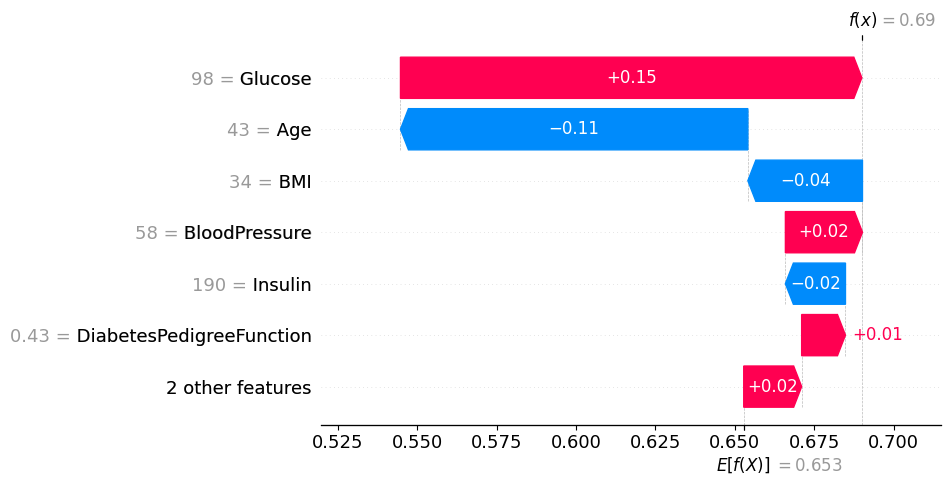

In [15]:
shap.plots.waterfall(kernel_shap_values[:,:,0][0], max_display=7)

TreeSHAP explanation

In [16]:
# Tree SHAP explanation
tree_shap_values = tree_shap_explainer(instance)
shap.force_plot(tree_shap_values[:,:,0],feature_names=X.columns)

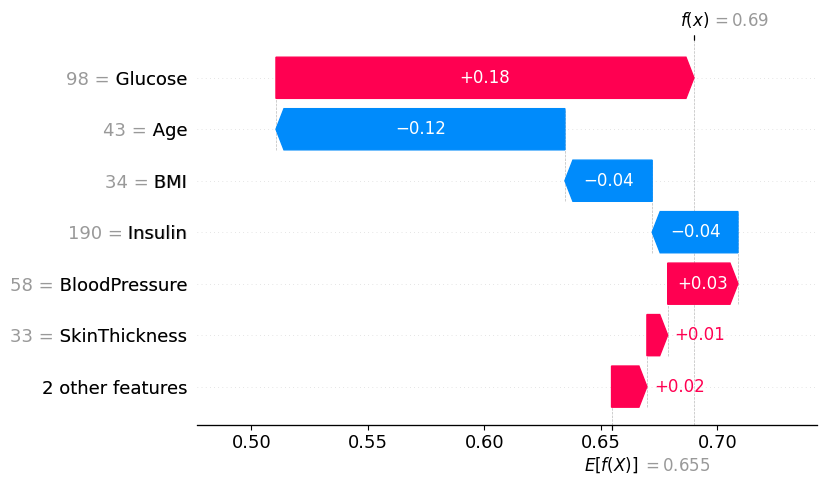

In [17]:
shap_values = tree_shap_explainer(X_test)
shap.plots.waterfall(shap_values[:,:,0][0], max_display=7)

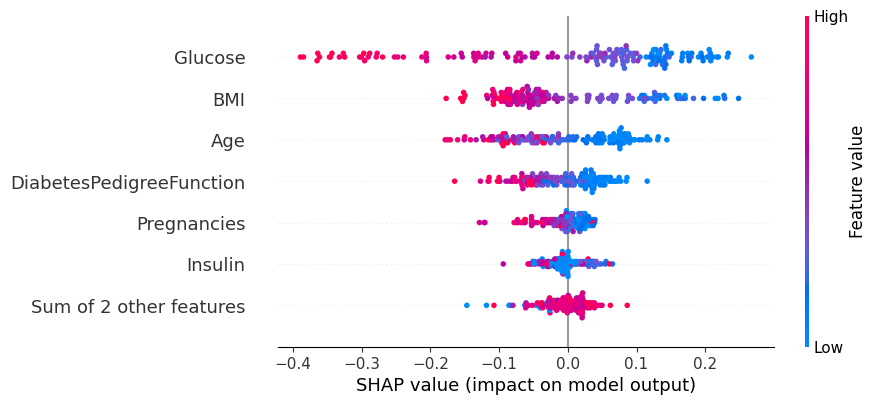

In [18]:
shap.plots.beeswarm(shap_values[:,:,0], max_display=7)

In [19]:
# Get global explanation
shap_values_global = tree_shap_explainer(X_train)

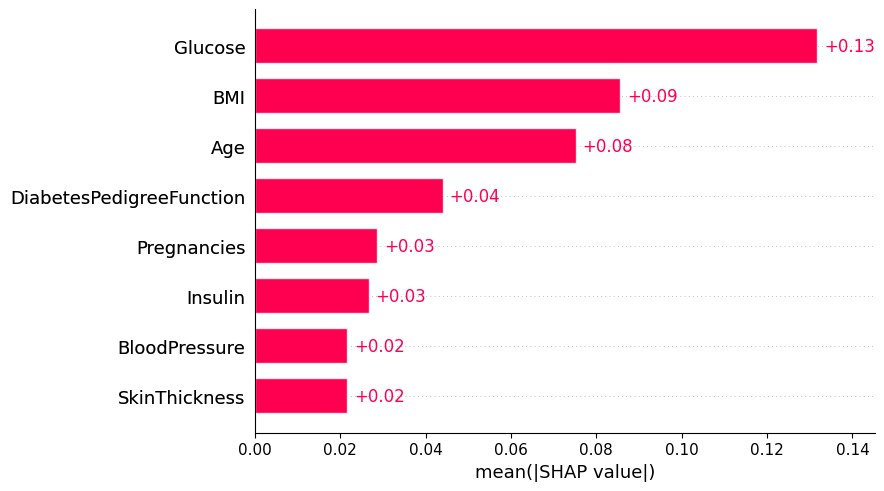

In [20]:
shap.plots.bar(shap_values_global[:,:,0])

## Framework example use

### F1 - Representativeness

All sub-properties here have fixed metrics, meaning they are case-independent

#### F1.1 - Scope

In [21]:
scope = {"LIME": 2, "KernelSHAP": 2, "TreeSHAP": 3}
# LIME provides local explanations
# KernelSHAP provides local explanations
# TreeSHAP supports global and local

#### F1.2 - Portability

In [22]:
portability = {"LIME": 2, "KernelSHAP": 2, "TreeSHAP": 1}
# LIME is model-agnostic; works with any black-box model.
# KernelShap similar to LIME
# TreeSHAP specific to tree-based models

#### F1.3 - Access

In [23]:
access_lime = {"Data Access": 2, "Model Access": 2}  # Needs data for initialization only (creating an explainer object) & requires access to the model’s prediction function
access_kernel_shap = {"Data Access": 2, "Model Access": 2}  # Similar to LIME
access_tree_shap = {"Data Access": 3, "Model Access": 0}  # No data required if applied to tree-based models directly & requires full model access

access = {"LIME": 4, "KernelSHAP": 4, "TreeSHAP": 3}  # Sum of Data Access and Model Access

#### F1.4 - Practicality

In [24]:
practicality_lime = {"Applicability": 2, "Scalability": 1}  # Data-agnostic, moderately scalable (computationally expensive for large datasets)
practicality_kernel_shap = {"Applicability": 2, "Scalability": 0}  # Data-agnostic & impractical for large datasets
practicality_tree_shap = {"Applicability": 1, "Scalability": 2}  # Data-specific but highly scalable (efficient for large datasets)

practicality = {"LIME": 3, "KernelSHAP": 2, "TreeSHAP": 3}  # Sum of Applicability and Scalability

#### F1 Summary table

In [25]:
# Calculate total scores
total_repr = {key: scope[key] + portability[key] + access[key] + practicality[key] for key in scope}

In [26]:
f1 = pd.DataFrame({
    "Scope (F1.1)": [scope["LIME"], scope["KernelSHAP"], scope["TreeSHAP"]],
    "Portability (F1.2)": [portability["LIME"], portability["KernelSHAP"], portability["TreeSHAP"]],
    "Access (F1.3)": [access["LIME"], access["KernelSHAP"], access["TreeSHAP"]],
    "Practicality (F1.4)": [practicality["LIME"], practicality["KernelSHAP"], practicality["TreeSHAP"]],
    "Total": [total_repr["LIME"], total_repr["KernelSHAP"], total_repr["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f1

,Scope (F1.1),Portability (F1.2),Access (F1.3),Practicality (F1.4),Total
LIME,2,2,4,3,11
KernelSHAP,2,2,4,2,10
TreeSHAP,3,1,3,3,10


### F2 - Structure

#### F2.1 - Expressive Power 

data type-dependent (and user)

In [27]:
# Predefined set of comprehensible formats - this is an example, to be updated based on user studies and/or user needs
C = {"decision_tree", "text_summary", "causal_diagram", "bar_plot", "analogy", "rule"}

In [28]:
# LIME parameters
n_lime = 1  # One explanatory output: feature importance
F_lime = ["table_summary", "bar_plot", "rule"] #It has rule in the terms of if feature_1 < 10, class = 1
score_lime = metrics.f2_1(n_lime, F_lime, C)
print(f"LIME Expressive Power Score: {score_lime}")
# KernelSHAP parameters
n_kernelshap = 1  # One explanatory output: Shapley values
F_kernelshap = ["bar_plot"]  
score_kernelshap = metrics.f2_1(n_kernelshap, F_kernelshap, C)
print(f"KernelSHAP Expressive Power Score: {score_kernelshap}")

# TreeSHAP parameters
n_treeshap = 1  # One explanatory output: Shapley values
F_treeshap = ["bar_plot", "interaction_plot", "beeswarm_plot"] 
score_treeshap = metrics.f2_1(n_treeshap, F_treeshap, C)
print(f"TreeSHAP Expressive Power Score: {score_treeshap}")

# Assign
expressive_power = {"LIME": score_lime, "KernelSHAP": score_kernelshap, "TreeSHAP": score_treeshap}

LIME Expressive Power Score: 4.7
KernelSHAP Expressive Power Score: 3.0
TreeSHAP Expressive Power Score: 4.3


#### F2.2 - Graphical Integrity
data type-dependent

In [29]:
graphical_integrity = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# They all show a positive/negative distinction with color-coded bars in tabular domain

#### F2.3 - Morphological Clarity

In [30]:
morphological_clarity = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# In all of them, longer bars indicate more relevant features in tabular domain

#### F2.4 - Layer Separation

In [31]:
layer_separation = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# In all of them, the feature values of the input instance are visible

#### F2 Summary table

In [32]:
# Calculate total scores
total_structure = {key: expressive_power[key] + graphical_integrity[key] + morphological_clarity[key] + layer_separation[key] for key in expressive_power}

In [33]:
f2 = pd.DataFrame({
    "Expressive Power (F2.1)": [expressive_power["LIME"], expressive_power["KernelSHAP"], expressive_power["TreeSHAP"]],
    "Graphical Integrity (F2.2)": [graphical_integrity["LIME"], graphical_integrity["KernelSHAP"], graphical_integrity["TreeSHAP"]],
    "Morphological Clarity (F2.3)": [morphological_clarity["LIME"], morphological_clarity["KernelSHAP"], morphological_clarity["TreeSHAP"]],
    "Layer Separation (F2.4)": [layer_separation["LIME"], layer_separation["KernelSHAP"], layer_separation["TreeSHAP"]],
    "Total": [total_structure["LIME"], total_structure["KernelSHAP"], total_structure["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f2

,Expressive Power (F2.1),Graphical Integrity (F2.2),Morphological Clarity (F2.3),Layer Separation (F2.4),Total
LIME,4.7,1,1,1,7.7
KernelSHAP,3.0,1,1,1,6.0
TreeSHAP,4.3,1,1,1,7.3


### F3 - Selectivity

In [34]:
explanation_size = {"LIME": metrics.f3(s=8, tunable = True), "KernelSHAP": metrics.f3(s=8, tunable = True), "TreeSHAP": metrics.f3(s=8,tunable = True)}
# In this case, both LIME and SHAP allow us to choose a max number of features to display, but there are certain methods that do not allow (e.g., PFI)

In [35]:
f3 = pd.DataFrame({
    "Total": [explanation_size["LIME"], explanation_size["KernelSHAP"], explanation_size["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f3

,Total
LIME,1.0
KernelSHAP,1.0
TreeSHAP,1.0


### F4 - Contrastivity

#### F4.1 - Contrastivity Level

In [49]:
contrastivity_level = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# All are contrastive to a predefined baseline, which is the average value
# CIU, for example, is contrastive to a predefined baseline (which can be chosen as the average or an other prediction) and to the current instance (like counterfactual explanations) - score is 2
# PDP, for example, simply show importance scores - score is 0

#### F4.2 - Target Sensitivity

Step 1: Initialize DiCE for Counterfactuals

In [51]:
# Step 1: Initialize DiCE for Counterfactuals
data_dice = Data(dataframe=data, continuous_features=X.columns.tolist(), outcome_name='Outcome')
model_dice = Model(model=model, backend='sklearn')
dice = Dice(data_dice, model_dice)

Step 2: Generate Nearest Counterfactual for test instance 0

In [52]:
# Step 2: Generate Nearest Counterfactual
query_instance = X_test.iloc[0:1]  # Original instance
counterfactual = dice.generate_counterfactuals(query_instance, total_CFs=1, desired_class="opposite")
cf_instance = counterfactual.cf_examples_list[0].final_cfs_df.drop('Outcome', axis=1)

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Step 3: Generate explanations for all instances in the dataset and compute d_max

In [37]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [54]:
# LIME
# Generate Explanations for 100 (just to have an idea) Instances in the Dataset
lime_values = []
for i in range(100):
    exp = lime_explainer.explain_instance(X_train.iloc[i].values, model.predict_proba)
    lime_values.append([v for _, v in exp.as_list()])

# Compute Pairwise Distances and d_max
lime_distances = euclidean_distances(lime_values)
d_max_lime = np.max(lime_distances)
print(round(d_max_lime,1))

0.7


In [56]:
# LIME
lime_exp_1 = lime_explainer.explain_instance(query_instance.values[0], model.predict_proba)
lime_values_1 = [v for _, v in lime_exp_1.as_list()]

lime_exp_2 = lime_explainer.explain_instance(cf_instance.values[0], model.predict_proba)
lime_values_2 = [v for _, v in lime_exp_2.as_list()]

# Compute Target Sensitivity (F4.2)
lime_f4_2 = metrics.f4_2(lime_values_1, lime_values_2, d_max=d_max_lime, distance_metric=euclidean)  # Use dataset-specific d_max for normalization
print("LIME Target Sensitivity (F4.2) Score:", lime_f4_2)

LIME Target Sensitivity (F4.2) Score: 0.1


In [72]:
# Kernel SHAP
# Generate SHAP Values for 100 (just to have an idea) Instances in the Dataset - this takes a while because it is kernelSHAP
kernel_shap_values = []
for i in range(100):
    exp = kernel_shap_explainer(X_train.iloc[i])
    kernel_shap_values.append(exp.values[:,0])

# Compute Pairwise Distances and d_max
kernel_shap_distances = euclidean_distances(kernel_shap_values)
d_max_kernel = np.max(kernel_shap_distances)
print(round(d_max_kernel,1))

0.7


In [86]:
# KernelSHAP
kernel_shap_1 = kernel_shap_explainer(query_instance)
kernel_shap_2 = kernel_shap_explainer(cf_instance)

kernel_values_1 = kernel_shap_1.values[:,:,0][0]
kernel_values_2 = kernel_shap_2.values[:,:,0][0]

kernel_f4_2 = metrics.f4_2(kernel_values_1, kernel_values_2, d_max=d_max_kernel, distance_metric=euclidean)
print("KernelSHAP Target Sensitivity (F4.2) Score:", kernel_f4_2)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

KernelSHAP Target Sensitivity (F4.2) Score: 0.2


In [ ]:
# Tree SHAP
# Generate SHAP Values for 100 (just to have an idea) Instances in the Dataset - here its is suuuper fast
tree_shap_values = []
for i in range(100):
    exp = tree_shap_explainer(X_train.iloc[i])
    tree_shap_values.append(exp.values[:,0])

# Compute Pairwise Distances and d_max
tree_shap_distances = euclidean_distances(tree_shap_values)
d_max_tree = np.max(tree_shap_distances)
print(round(d_max_tree,1))

0.7


In [89]:
# treeSHAP
tree_shap_1 = tree_shap_explainer(query_instance)
tree_shap_2 = tree_shap_explainer(cf_instance)

tree_values_1 = tree_shap_1.values[:,:,0][0]
tree_values_2 = tree_shap_2.values[:,:,0][0]

tree_f4_2 = metrics.f4_2(tree_values_1, tree_values_2, d_max=d_max_tree, distance_metric=euclidean)
print("treeSHAP Target Sensitivity (F4.2) Score:", tree_f4_2)

treeSHAP Target Sensitivity (F4.2) Score: 0.2


In [90]:
target_sensitivity = {"LIME": lime_f4_2, "KernelSHAP": kernel_f4_2, "TreeSHAP": tree_f4_2}

#### F4 Summary table

In [92]:
# Calculate total scores
total_contrast = {key: contrastivity_level[key] + target_sensitivity[key] for key in contrastivity_level}

In [93]:
f4 = pd.DataFrame({
    "Contrastivity Level (F4.1)": [contrastivity_level["LIME"], contrastivity_level["KernelSHAP"], contrastivity_level["TreeSHAP"]],
    "Target Sensitivity (F4.2)": [target_sensitivity["LIME"], target_sensitivity["KernelSHAP"], target_sensitivity["TreeSHAP"]],
    "Total": [total_contrast["LIME"], total_contrast["KernelSHAP"], total_contrast["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f4

,Contrastivity Level (F4.1),Target Sensitivity (F4.2),Total
LIME,1,0.1,1.1
KernelSHAP,1,0.2,1.2
TreeSHAP,1,0.2,1.2


### F5 - Interactivity

These are also fixed metrics, as they are inherent to the XAI method per se

#### F5.1 - Interaction Level

In [100]:
interaction_level = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# In all of them: no built-in interactive tools, but API allows developers to implement interaction easily

#### F5.2 - Controllability

In [102]:
controllability = {"LIME": 2, "KernelSHAP": 2, "TreeSHAP": 2}
# Explanations can be refined by choosing specific features or adjusting the number of features shown, offering limited control.

#### F5 Summary Table

In [103]:
# Calculate total scores
total_interactivity = {key: interaction_level[key] + controllability[key] for key in interaction_level}

In [104]:
f5 = pd.DataFrame({
    "Contrastivity Level (F5.1)": [interaction_level["LIME"], interaction_level["KernelSHAP"], interaction_level["TreeSHAP"]],
    "Target Sensitivity (F5.2)": [controllability["LIME"], controllability["KernelSHAP"], controllability["TreeSHAP"]],
    "Total": [total_interactivity["LIME"], total_interactivity["KernelSHAP"], total_interactivity["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f5

,Contrastivity Level (F4.1),Target Sensitivity (F4.2),Total
LIME,1,2,3
KernelSHAP,1,2,3
TreeSHAP,1,2,3


### F6 - Fidelity

#### F6.1 - Fidelity Check 
(fixed)

In [38]:
fidelity_check = {"LIME": 0, "KernelSHAP": 0, "TreeSHAP": 1}
# Surrogate model or linearity assumptions used in LIME & kernelSHAP with default linear kernel

#### F6.2 - Surrogate Agreement

In [40]:
# Get 100 predictions
bb_preds = model.predict_proba(X_train.iloc[0:100])

In [41]:
# LIME
# Generate Explanations for 100 Instances in the Dataset (Calculate faithfulness over 100)
lime_preds = []
for i in range(100):
    exp = lime_explainer.explain_instance(X_train.iloc[i].values, model.predict_proba)
    # lime computes linear aprox for class 1 - diabetes
    lime_preds.append([exp.local_pred[0]])

# Calculate Surrogate Agreement for LIME - bb preds for class 1
lime_f6_2 = metrics.f6_2(bb_preds[:, 1], lime_preds)
print("LIME Surrogate Agreement (F6.2):", lime_f6_2)

LIME Surrogate Agreement (F6.2): 0.7


In [62]:
# Kernel SHAP
# Generate SHAP Values for 100 Instances in the Dataset - this takes a while because it is kernelSHAP

base_value = kernel_shap_explainer.expected_value[0]  # Base value for class 0

kernel_preds = []
for i in range(100):
    exp = kernel_shap_explainer(X_train.iloc[i])
    surrogate_pred_shap = base_value + sum(exp.values[:,0]) #for class 0
    kernel_preds.append([surrogate_pred_shap])

# Calculate Surrogate Agreement for kernelSHAP - bb preds for class 0
kernel_f6_2 = metrics.f6_2(bb_preds[:, 0], kernel_preds)
print("KernelSHAP Surrogate Agreement (F6.2):", kernel_f6_2)

KernelSHAP Surrogate Agreement (F6.2): 0.6


In [63]:
surrogate_agreement = {"LIME": lime_f6_2, "KernelSHAP": kernel_f6_2, "TreeSHAP": 1}
#TreeSHAP is 1 because no surrogate model is used

#### F6 Summary Table

In [64]:
# Calculate total scores
total_fidelity = {key: fidelity_check[key] + surrogate_agreement[key] for key in fidelity_check}

In [65]:
f6 = pd.DataFrame({
    "Fidelity Check (F6.1)": [fidelity_check["LIME"], fidelity_check["KernelSHAP"], fidelity_check["TreeSHAP"]],
    "Surrogate Agreement (F6.2)": [surrogate_agreement["LIME"], surrogate_agreement["KernelSHAP"], surrogate_agreement["TreeSHAP"]],
    "Total": [total_fidelity["LIME"], total_fidelity["KernelSHAP"], total_fidelity["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f6

,Fidelity Check (F6.1),Surrogate Agreement (F6.2),Total
LIME,0,0.7,0.7
KernelSHAP,0,0.6,0.6
TreeSHAP,1,1.0,2.0


### F7 - Faithfulness

#### F7.1 - Incremental Deletion 
(use when comparing local methods)

In [18]:
# Get predictions for the test set
probs = model.predict_proba(X_test)[:, 1]  # Probability for class 1

# Select 30 instances where class 1 probability > 0.6
selected_instances = X_test[probs > 0.6].iloc[:30]

In [19]:
# Define a base instance with optimal values for predicting class 0
# Manually defining the base instance
base_instance = {
    'Pregnancies': 0, 
    'Glucose': 70,
    'BloodPressure': 60, 
    'SkinThickness': 15, 
    'Insulin': 80, 
    'BMI': 22.0, 
    'DiabetesPedigreeFunction': 0.1, 
    'Age': 22
}

# Convert to numpy array (to match the format of `instance` in the function)
base_instance_array = np.array([base_instance[feature] for feature in X.columns]).reshape(1, -1)

In [20]:
selected_instances.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
336,0,117,0,0,0,33.8,0.932,44
568,4,154,72,29,126,31.3,0.338,37
212,7,179,95,31,0,34.2,0.164,60
209,7,184,84,33,0,35.5,0.355,41
120,0,162,76,56,100,53.2,0.759,25


In [21]:
instance_test = selected_instances.iloc[0].values.reshape(1, -1)

# We want predictions for class 1

# LIME
lime_explanation_test = lime_explainer.explain_instance(instance_test[0], model.predict_proba)
# Extract the feature indices
feature_indices = [index for index, _ in lime_explanation_test.as_map()[1]]
# Map the feature indices to feature names
lime_feature_ranking = [X.columns[index] for index in feature_indices]

# KernelSHAP
kernel_shap_test = kernel_shap_explainer(instance_test)
kernel_shap_feature_ranking = np.argsort(-np.abs(kernel_shap_test.values[:,:,1][0]))  # Ranking by absolute Shapley values
kernel_feature_ranking = [X.columns[index] for index in kernel_shap_feature_ranking]

# treeSHAP
tree_shap_test = tree_shap_explainer(instance_test)
tree_shap_feature_ranking = np.argsort(-np.abs(tree_shap_test.values[:,:,1][0]))  # Ranking by absolute Shapley values
tree_feature_ranking = [X.columns[index] for index in tree_shap_feature_ranking]

c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


In [22]:
print(lime_feature_ranking)
print(kernel_feature_ranking)
print(tree_feature_ranking)

['Age', 'DiabetesPedigreeFunction', 'Glucose', 'BMI', 'Pregnancies', 'BloodPressure', 'Insulin', 'SkinThickness']
['BMI', 'Age', 'DiabetesPedigreeFunction', 'BloodPressure', 'Insulin', 'SkinThickness', 'Glucose', 'Pregnancies']
['BMI', 'Age', 'DiabetesPedigreeFunction', 'BloodPressure', 'SkinThickness', 'Insulin', 'Pregnancies', 'Glucose']


In [23]:
# Perform Incremental Deletion
lime_probs, lime_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, lime_feature_ranking, X)
kernel_probs, kernel_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, kernel_feature_ranking, X)
tree_probs, tree_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, tree_feature_ranking, X)

c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warni

In [28]:
# Generate a random feature ranking
random_feature_ranking = np.random.permutation(X.columns).tolist()
# Perform Incremental Deletion
random_probs, random_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, random_feature_ranking, X)

c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warni

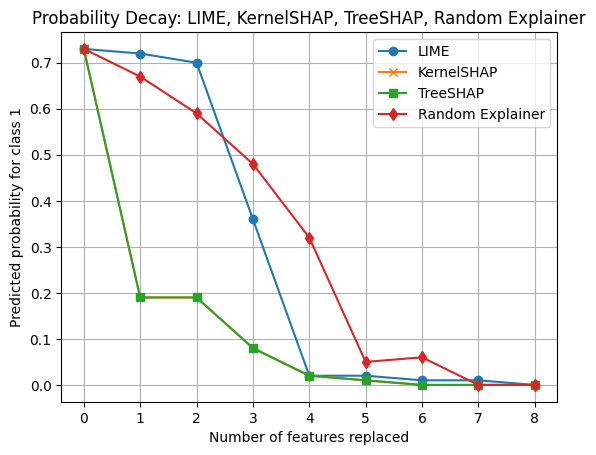

In [29]:
# Plot probability decay curves
plt.plot(range(len(lime_probs)), lime_probs, label='LIME', marker='o')
plt.plot(range(len(kernel_probs)), kernel_probs, label='KernelSHAP', marker='x')
plt.plot(range(len(tree_probs)), tree_probs, label='TreeSHAP', marker='s')
plt.plot(range(len(random_probs)), random_probs, label='Random Explainer', marker='d')

# Customize plot
plt.xlabel('Number of features replaced')
plt.ylabel('Predicted probability for class 1')
plt.title('Probability Decay: LIME, KernelSHAP, TreeSHAP, Random Explainer')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Metric for just one instance
print("F7.1 for LIME (single instance):", metrics.f7_1_result(lime_auc, random_auc))
print("F7.1 for kernelSHAP (single instance):", metrics.f7_1_result(kernel_auc, random_auc))
print("F7.1 for treeSHAP (single instance):", metrics.f7_1_result(tree_auc, random_auc))

F7.1 for LIME (single instance): 0.1
F7.1 for kernelSHAP (single instance): 0.7
F7.1 for treeSHAP (single instance): 0.7


In [32]:
# Now for N=30 selected instances:

# Initialize lists to store AUC differences for each method
lime_scores_auc = []
kernel_scores_auc = []
tree_scores_auc = []

# Loop over all instances in selected_instances
for index, row in selected_instances.iterrows():
    instance_test = row.values.reshape(1, -1)
    
    # LIME feature ranking
    lime_explanation_test = lime_explainer.explain_instance(instance_test[0], model.predict_proba)
    feature_indices = [index for index, _ in lime_explanation_test.as_map()[1]]
    lime_feature_ranking = [X.columns[index] for index in feature_indices]
    
    # KernelSHAP feature ranking
    kernel_shap_test = kernel_shap_explainer(instance_test)
    kernel_shap_feature_ranking = np.argsort(-np.abs(kernel_shap_test.values[:,:,1][0]))
    kernel_feature_ranking = [X.columns[index] for index in kernel_shap_feature_ranking]
    
    # TreeSHAP feature ranking
    tree_shap_test = tree_shap_explainer(instance_test)
    tree_shap_feature_ranking = np.argsort(-np.abs(tree_shap_test.values[:,:,1][0]))
    tree_feature_ranking = [X.columns[index] for index in tree_shap_feature_ranking]
    
    # Random feature ranking
    random_feature_ranking = np.random.permutation(X.columns).tolist()
    
    # Perform Incremental Deletion
    lime_probs, lime_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, lime_feature_ranking, X)
    kernel_probs, kernel_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, kernel_feature_ranking, X)
    tree_probs, tree_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, tree_feature_ranking, X)
    random_probs, random_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, random_feature_ranking, X)
    
    # Calculate normalized F7.1 scores
    lime_scores_auc.append(metrics.f7_1_result(lime_auc, random_auc))
    kernel_scores_auc.append(metrics.f7_1_result(kernel_auc, random_auc))
    tree_scores_auc.append(metrics.f7_1_result(tree_auc, random_auc))

c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestCl

In [36]:
# Compute Incremental Deletion F7.1 scores
incremental_deletion_lime = round(np.mean(lime_scores_auc),1)
incremental_deletion_kernel = round(np.mean(kernel_scores_auc),1)
incremental_deletion_tree = round(np.mean(tree_scores_auc),1)

# Print results
print("Incremental Deletion F7.1 Score (LIME):", incremental_deletion_lime)
print("Incremental Deletion F7.1 Score (KernelSHAP):", incremental_deletion_kernel)
print("Incremental Deletion F7.1 Score (TreeSHAP):", incremental_deletion_tree)

# Score 0: : The XAI method performs no better than random feature selection.
# Score 1: The XAI method perfectly identifies the most impactful features, leading to a steeper probability decay than the random explainer.

Incremental Deletion F7.1 Score (LIME): 0.4
Incremental Deletion F7.1 Score (KernelSHAP): 0.5
Incremental Deletion F7.1 Score (TreeSHAP): 0.5


In [102]:
incremental_deletion = {"LIME": incremental_deletion_lime, "KernelSHAP": incremental_deletion_kernel, "TreeSHAP": incremental_deletion_tree}
# This is for local methods

#### F7.2 - ROAR 
(use when comparing global methods)

In [52]:
# Calculate mean absolute Shapley values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values_global.values[:,:,0]), axis=0)

# Map these values to the corresponding feature names
feature_importances = dict(zip(X_train.columns, mean_abs_shap_values))

# Sort by importance
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

In [55]:
sorted_feature_importances

{'Glucose': 0.1317851277940372,
 'BMI': 0.08564511779688302,
 'Age': 0.07516650749322522,
 'DiabetesPedigreeFunction': 0.044050945972843716,
 'Pregnancies': 0.028707520836436063,
 'Insulin': 0.026737492176333595,
 'BloodPressure': 0.021655087051952196,
 'SkinThickness': 0.021599398010736976}

In [57]:
tree_feature_ranking_global = [feature for feature in sorted_feature_importances]
print(tree_feature_ranking_global)

['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'Insulin', 'BloodPressure', 'SkinThickness']


In [81]:
# Generate a random global feature ranking
random_feature_ranking_global = np.random.permutation(X.columns).tolist()

In [ ]:
# Apply ROAR metric to TreeSHAP
f7_2_tree_shap, acc_tree, acc_random = metrics.f7_2_classification(
    model, X_train, X_test, y_train, y_test, tree_feature_ranking, random_feature_ranking_global
)

print("ROAR (F7.2) for TreeSHAP:", f7_2_tree_shap)

ROAR (F7.2) for TreeSHAP: 0.1


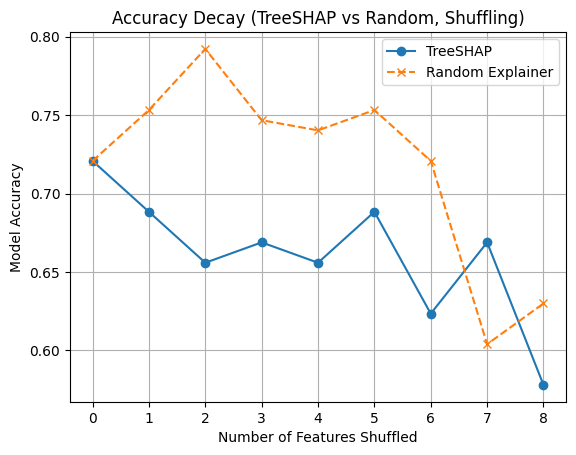

In [96]:
# Plot accuracy decay
plt.plot(range(len(acc_tree)), acc_tree, label="TreeSHAP", marker='o', linestyle='-')
plt.plot(range(len(acc_random)), acc_random, label="Random Explainer", marker='x', linestyle='--')

# Add labels and legend
plt.xlabel("Number of Features Shuffled")
plt.ylabel("Model Accuracy")
plt.title("Accuracy Decay (TreeSHAP vs Random, Shuffling)")
plt.legend()
plt.grid(True)
plt.show()

In [98]:
print(random_feature_ranking_global)
 # We actually see that BMI and BloodPressure removal increase model accuracy...
# This is just an example, we probably would need to remove zeros & outliers in the data, but it is not the purpose here

['BMI', 'BloodPressure', 'SkinThickness', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies', 'Glucose', 'Insulin']


In [101]:
roar = {"LIME": None, "KernelSHAP": None, "TreeSHAP": f7_2_tree_shap}
# This is for global methods

#### F7.3 - White box

In [324]:
# Define the linear function
def linfunc(inputs):
    """
    Linear function: Weighted sum of inputs.
    Coefficients: 0.4, 0.3, 0.2, 0.1 # just an example, it can be changed
    """
    return 0.4 * inputs[:, 0] + 0.3 * inputs[:, 1] + 0.2 * inputs[:, 2] + 0.1 * inputs[:, 3]

In [325]:
# Generate the dataset
x1 = x2 = x3 = x4 = np.linspace(0, 1, 21)  # Sequence from 0 to 1, step 0.05
pm = np.array(np.meshgrid(x1, x2, x3, x4)).T.reshape(-1, 4)  # Create the grid

# Ground-truth outputs
y = linfunc(pm)

In [326]:
np.mean(y) #average prediction --> E(X)

0.5

In [327]:
# Define instances to compare with explanations
c = np.array([[1, 0.66, 0.33, 0]])        # Specific instance
c1 = np.array([[0.5, 0.5, 0.5, 0.5]])     # All values are average
c2 = np.array([[1, 1, 1, 1]])             # All values are maximum

In [328]:
# Define the linear function coefficients
coefficients = [0.4, 0.3, 0.2, 0.1]
E_X = np.mean(y)  # 0.5 - Average prediction for all features

# Define a function to calculate feature influence
def compute_influence(coefficients, feature_values, E_X=0.5):
    """
    Compute feature influence for an instance. - from decision theory - more in https://doi-org.proxy.bnl.lu/10.1007/978-3-031-44064-9_14
    
    Parameters:
        coefficients (list): Linear coefficients for the features (w_i).
        feature_values (list): Values of the features for a given instance (x_i).
        E_X (float): Expected value of each feature (default is 0.5).
    
    Returns:
        list: Feature influence values.
    """
    return [w * x - w * E_X for w, x in zip(coefficients, feature_values)]

# Define a function to construct the table
def construct_table(instance, coefficients, xai_explanations, feature_names):
    """
    Construct a table with feature values, global importance, feature influence, and XAI coefficients.
    
    Parameters:
        instance (array): Feature values for the instance (x_i).
        coefficients (list): Linear coefficients for the features (w_i).
        xai_explanations (dict): Explanation coefficients from different XAI methods (e.g., LIME, SHAP).
        feature_names (list): Names of the features.
    
    Returns:
        DataFrame: Table summarizing the values.
    """
    # Compute feature influence
    influences = compute_influence(coefficients, instance)
    
    # Create the table
    data = {
        "Feature": feature_names,
        "Feature Value (x_i)": instance,
        "Global Importance (w_i)": coefficients,
        "Feature Influence": influences,
    }
    
    # Add XAI coefficients
    for method, explanation in xai_explanations.items():
        data[f"{method} Coefficient"] = explanation
    
    return pd.DataFrame(data)

In [329]:
# Create explainers for linear function
lime_explainer_linear = LimeTabularExplainer(pm, feature_names=["x1", "x2", "x3", "x4"], mode='regression')
kernel_shap_explainer_linear = shap.KernelExplainer(linfunc, shap.sample(pm, 1000)) # I am sampling to reduce the running time - limitation in kernelSHAP!

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [330]:
# For instance c:
lime_exp_c = lime_explainer_linear.explain_instance(c[0], linfunc)
lime_explanation_c = np.array([value for _, value in lime_exp_c.as_list()])  # Extract feature influence
shap_values_c = kernel_shap_explainer_linear.shap_values(c)
kernelshap_explanation_c = shap_values_c[0]

# For instance c1:
lime_exp_c1 = lime_explainer_linear.explain_instance(c1[0], linfunc)
lime_explanation_c1 = np.array([value for _, value in lime_exp_c1.as_list()])  # Extract feature influence
shap_values_c1 = kernel_shap_explainer_linear.shap_values(c1)
kernelshap_explanation_c1 = shap_values_c1[0]

# For instance c2:
lime_exp_c2 = lime_explainer_linear.explain_instance(c2[0], linfunc)
lime_explanation_c2 = np.array([value for _, value in lime_exp_c2.as_list()])  # Extract feature influence
shap_values_c2 = kernel_shap_explainer_linear.shap_values(c2)
kernelshap_explanation_c2 = shap_values_c2[0]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


In [331]:
feature_names = ["x1", "x2", "x3", "x4"]
# Explanation for c
xai_explanations_c = {
    "LIME": lime_explanation_c,
    "KernelSHAP": kernelshap_explanation_c
}

# Construct the table
table_c = construct_table(c[0], coefficients, xai_explanations_c, feature_names)
table_c

,Feature,Feature Value (x_i),Global Importance (w_i),Feature Influence,LIME Coefficient,KernelSHAP Coefficient
0,x1,1.00,0.4,0.200,0.205463,0.197600
1,x2,0.66,0.3,0.048,0.053658,0.051555
2,x3,0.33,0.2,-0.034,-0.047043,-0.032540
3,x4,0.00,0.1,-0.050,-0.022728,-0.049570


In [332]:
print(metrics.f7_3_compute_agreement(lime_explanation_c, table_c["Feature Influence"]))
print(metrics.f7_3_compute_agreement(kernelshap_explanation_c, table_c["Feature Influence"]))

0.76
0.97


In [333]:
# Explanation for c1
xai_explanations_c1 = {
    "LIME": lime_explanation_c1,
    "KernelSHAP": kernelshap_explanation_c1
}

# Construct the table
table_c1 = construct_table(c1[0], coefficients, xai_explanations_c1, feature_names)
table_c1

,Feature,Feature Value (x_i),Global Importance (w_i),Feature Influence,LIME Coefficient,KernelSHAP Coefficient
0,x1,0.5,0.4,0.0,-0.059268,-0.002400
1,x2,0.5,0.3,0.0,-0.036148,0.003555
2,x3,0.5,0.2,0.0,-0.021262,0.001460
3,x4,0.5,0.1,0.0,-0.018677,0.000430


In [334]:
# Explanation for c2
xai_explanations_c2 = {
    "LIME": lime_explanation_c2,
    "KernelSHAP": kernelshap_explanation_c2
}

# Construct the table
table_c2 = construct_table(c2[0], coefficients, xai_explanations_c2, feature_names)
table_c2

,Feature,Feature Value (x_i),Global Importance (w_i),Feature Influence,LIME Coefficient,KernelSHAP Coefficient
0,x1,1,0.4,0.20,0.207680,0.197600
1,x2,1,0.3,0.15,0.160529,0.153555
2,x3,1,0.2,0.10,0.101269,0.101460
3,x4,1,0.1,0.05,0.054330,0.050430


We can see that LIME and kernelSHAP are in fact computing feature influence scores (compared to the average baseline), and not feature importance scores.
Let's compare with the real feature influence scores (we can already tell that SHAP does a better job than LIME).

In [335]:
feature_names = ["x1", "x2", "x3", "x4"]

# Select 100 random indices
random_indices = np.random.choice(range(len(pm)), 100, replace=False)

# Initialize lists to store agreements
lime_agreement = []
kernel_agreement = []

for i in random_indices:
    # LIME Explanation
    lime_exp = lime_explainer_linear.explain_instance(pm[i], linfunc)
    lime_explanation = np.array([value for _, value in lime_exp.as_list()])  # Extract feature influence
    
    # KernelSHAP Explanation
    shap_values = kernel_shap_explainer_linear.shap_values(pm[i:i+1])  # KernelSHAP expects 2D input
    kernelshap_explanation = shap_values[0]  # Use the first output (assumes single target)
    
    # Construct XAI explanations dictionary
    xai_explanations = {
        "LIME": lime_explanation,
        "KernelSHAP": kernelshap_explanation
    }
    
    # Construct the table
    table = construct_table(pm[i], coefficients, xai_explanations, feature_names)
    
    # Compute agreement scores and store
    lime_agreement.append(metrics.f7_3_compute_agreement(lime_explanation, table["Feature Influence"]))
    kernel_agreement.append(metrics.f7_3_compute_agreement(kernelshap_explanation, table["Feature Influence"]))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


In [337]:
# Compute mean agreement
mean_lime_agreement = np.mean(lime_agreement)
mean_kernel_agreement = np.mean(kernel_agreement)

print(f"Mean Agreement for LIME: {mean_lime_agreement:.2f}")
print(f"Mean Agreement for KernelSHAP: {mean_kernel_agreement:.2f}")

Mean Agreement for LIME: 0.61
Mean Agreement for KernelSHAP: 0.90


Do a simple DT to evaluate treeSHAP

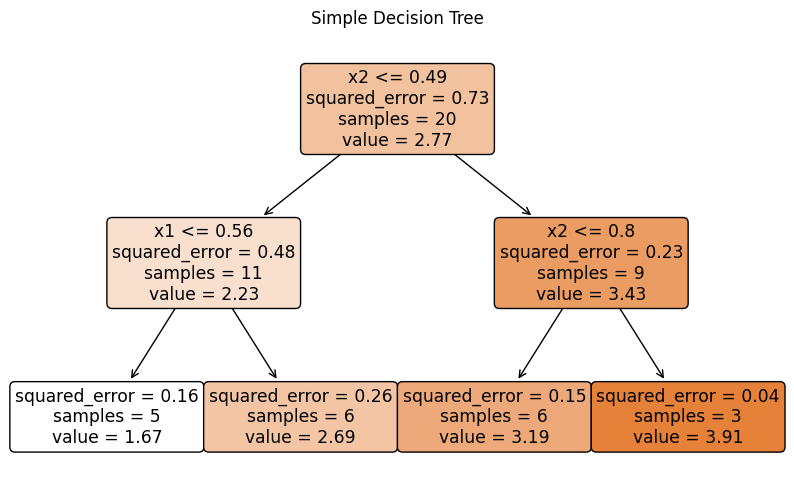

In [301]:
# Generate a simple dataset
np.random.seed(42)
X_simple = pd.DataFrame({
    "x1": np.random.rand(20),  # Random values for feature 1
    "x2": np.random.rand(20),  # Random values for feature 2
})
y_simple = 2 * X_simple["x1"] + 3 * X_simple["x2"] + np.random.rand(20)  # Random target variable

# Train a simple decision tree
simple_tree = DecisionTreeRegressor(max_depth=2, random_state=42)
simple_tree.fit(X_simple, y_simple)

# Visualize the decision tree
plt.figure(figsize=(10, 6))
plot_tree(
    simple_tree,
    feature_names=X_simple.columns,
    filled=True,
    rounded=True,
    precision=2
)
plt.title("Simple Decision Tree")
plt.show()

In [320]:
# 3. Compute TreeSHAP explanations
tree_explainer = shap.TreeExplainer(simple_tree)
shap_values_tree = tree_explainer(X_simple)
# Calculate mean absolute Shapley values for each feature
global_shap_tree = np.mean(np.abs(shap_values.values), axis=0)
simple_tree_coefs = simple_tree.feature_importances_

# Compute agreement
tree_shap_agreement = metrics.f7_3_compute_agreement(global_shap_tree, simple_tree_coefs)
print(f"Agreement for treeSHAP: {tree_shap_agreement}")

Agreement for treeSHAP: 0.89


In [350]:
white_box = {"LIME": metrics.f7_3_score(mean_lime_agreement), "KernelSHAP": metrics.f7_3_score(mean_kernel_agreement), "TreeSHAP": metrics.f7_3_score(tree_shap_agreement)}

#### F7 Summary Table

In [345]:
# Calculate total scores - not including ROAR here, comparing all local methods
total_faithfulness = {key: incremental_deletion[key] + white_box[key] for key in incremental_deletion}

In [346]:
f7 = pd.DataFrame({
    "Incremental Deletion (F7.1)": [incremental_deletion["LIME"], incremental_deletion["KernelSHAP"], incremental_deletion["TreeSHAP"]],
    "ROAR (F7.2)": [roar["LIME"], roar["KernelSHAP"], roar["TreeSHAP"]],
    "White-Box Check (F7.3)": [white_box["LIME"], white_box["KernelSHAP"], white_box["TreeSHAP"]],
    "Total": [total_faithfulness["LIME"], total_faithfulness["KernelSHAP"], total_faithfulness["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f7

,Incremental Deletion (F7.1),ROAR (F7.2),White-Box Check (F7.3),Total
LIME,0.4,NaN,1,1.4
KernelSHAP,0.5,NaN,2,2.5
TreeSHAP,0.5,0.1,2,2.5


### F8 - Truthfulness

### F9 - Stability

### F10 - Certainty

### F11 - Speed